In [1]:
import json

data = json.load(open('config.json', 'r', encoding='utf8'))

In [2]:
data.keys()

dict_keys(['completed', 'step_1', 'step_2', 'step_3'])

In [3]:
import pandas as pd

In [4]:
df_arr = pd.DataFrame({
    'date': data['step_2']['xs'],
    'n_arr': data['step_2']['ys']
})
df_arr

,date,n_arr
0,2024-10-01,2.116019
1,2024-10-02,2.116029
2,2024-10-03,2.116042
3,2024-10-04,2.116061
4,2024-10-05,2.116089
...,...,...
146,2025-02-24,2.116000
147,2025-02-25,2.116000
148,2025-02-26,2.116000
149,2025-02-27,2.116000


In [5]:
df_arr.date[0]

'2024-10-01'

In [6]:
df_arr.date = pd.to_datetime(df_arr.date)
df_arr.date[:10]

0   2024-10-01
1   2024-10-02
2   2024-10-03
3   2024-10-04
4   2024-10-05
5   2024-10-06
6   2024-10-07
7   2024-10-08
8   2024-10-09
9   2024-10-10
Name: date, dtype: datetime64[ns]

<Axes: xlabel='date'>

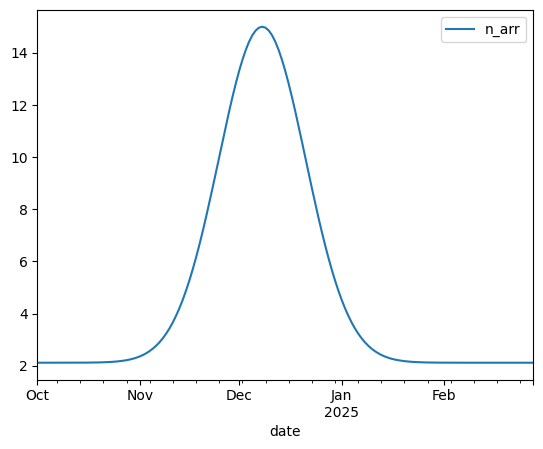

In [7]:
df_arr.plot(x='date', y='n_arr')

In [18]:
from scipy import stats

In [28]:
n = data['step_3']['selected_dists']['paeds']
params = data['step_3']['dists']['paeds'][n]

dist_paeds = getattr(stats, n)(**params)

print(dist_paeds.dist.name)
dist_paeds.kwds

genhyperbolic


{'p': -0.3023685348444624,
 'a': 2.237863755025021,
 'b': 2.2194479387233113,
 'loc': 0.3100321434414689,
 'scale': 0.37992439044793436}

In [29]:
n = data['step_3']['selected_dists']['adult']
params = data['step_3']['dists']['adult'][n]

dist_adult = getattr(stats, n)(**params)

print(dist_adult.dist.name)
dist_adult.kwds

genhyperbolic


{'p': -0.031781317536850616,
 'a': 3.405172001096986,
 'b': 3.389108415988021,
 'loc': 0.12084849786926694,
 'scale': 0.47536291525568297}

In [30]:
n = data['step_3']['selected_dists']['senior']
params = data['step_3']['dists']['senior'][n]

dist_senior = getattr(stats, n)(**params)

print(dist_senior.dist.name)
dist_senior.kwds

genexpon


{'a': 0.09966757968288487,
 'b': 0.2229084323738606,
 'c': 4.693407483531251,
 'loc': 0.003021774062861417,
 'scale': 4.034911780519071}